# Classification Algorithm Analysis
Notebook to analyze data generated from `classification_algo` in `crawler.py`.

## Imports

In [4]:
import os
import pandas as pd
import json
import statistics
import importlib.util
import sys
from pathlib import Path
import yaml

sys.path.append("../utils")
import utils
from image_shingle import ImageShingle

ModuleNotFoundError: No module named 'yaml'

## Constants

In [3]:
MODULE_DIR = Path().resolve().parent

CRAWL_NAME = 'slurm-test'
CRAWL_PATH = MODULE_DIR / CRAWL_NAME

with open("example.yaml", "r") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

print(config.CRAWL_NAME)

stupid


## Crawl Sanity Checks

In [3]:
PATHS = []
times = []
with open(f"crawls/{CRAWL_NAME}/results.json") as results:
    results = json.load(results)
    for path in results:
        if results[path].get("crawl_failure") is None:
            PATHS.append(path)
            times.append(results[path].get("time"))

print(len(PATHS))

37


In [24]:
print("mean", statistics.mean(times))
print("sum", sum(times))
    

mean 1394.749192895116
sum 51605.72013711929


In [4]:
def compare_clickstreams(baseline: str, comparison: str, name: str) -> pd.DataFrame:
    rows_list = []

    for i, path in enumerate(PATHS):
        print(f"Analyzing site {i+1}/{len(PATHS)}")
        clickstreams = utils.get_directories(path)

        sample_size = 0

        total_clickstreams = 0
        website_sum = 0

        for clickstream in clickstreams:

            total_actions = 0
            clickstream_sum = 0

            for _ in range(10):
                baseline_base_path = f"{clickstream}/{baseline}-{total_actions}"
                comparison_path = f"{clickstream}/{comparison}-{total_actions}.png"
                
                if os.path.isfile(comparison_path):
                    comparison_shingle = ImageShingle(comparison_path)

                    max_similarity = 0
                    for i in range(1, 11):
                        baseline_path = f"{baseline_base_path}-{i}.png"
                        if os.path.isfile(baseline_path):
                            baseline_shingle = ImageShingle(baseline_path)
                            max_similarity = max(max_similarity, baseline_shingle.compare(comparison_shingle))

                    clickstream_sum += max_similarity
                    total_actions += 1

            sample_size += total_actions

            if total_actions != 0:
                clickstream_similarity = clickstream_sum / total_actions
                website_sum += clickstream_similarity

                total_clickstreams += 1
        
        if total_clickstreams != 0:
            website_similarity = website_sum / total_clickstreams
            website_difference = 1 - website_similarity

            website = os.path.basename(os.path.normpath(path))
            rows_list.append({
                "website": website,
                f"difference_{name}": website_difference,
                f"sample_size_{name}": sample_size
            })

    return pd.DataFrame(rows_list)

In [5]:
def compare_with_control() -> pd.DataFrame:
    rows_list = []

    for i, path in enumerate(PATHS):
        print(f"Analyzing site {i+1}/{len(PATHS)}")

        clickstreams = utils.get_directories(path)

        sample_size = 0

        total_clickstreams = 0

        clickstream_sims = []
        for clickstream in clickstreams:

            total_actions = 0
            clickstream_sum = 0

            for _ in range(10):
                baseline_base_path = f"{clickstream}/baseline-{total_actions}"
                control_path = f"{clickstream}/control-{total_actions}.png"
                experimental_path = f"{clickstream}/experimental-{total_actions}.png"
                
                if os.path.isfile(control_path) and os.path.isfile(experimental_path):
                    baseline_shingles = []
                    for i in range(1, 11):
                        baseline_path = f"{baseline_base_path}-{i}.png"
                        if os.path.isfile(baseline_path):
                            baseline_shingles.append(ImageShingle(baseline_path))

                    control_shingle = ImageShingle(control_path)
                    experimental_shingle = ImageShingle(experimental_path)

                    try:
                        sim = ImageShingle.compare_with_controls(control_shingle, baseline_shingles, experimental_shingle)
                        
                        if sim != 1:
                            print(baseline_base_path)
                            with open("logs.txt", "a") as file:
                                file.write(baseline_base_path + "\n")
                        
                        clickstream_sum += sim
                    except:
                        print(baseline_shingles)
                    total_actions += 1

            sample_size += total_actions

            if total_actions != 0:
                clickstream_similarity = clickstream_sum / total_actions
                clickstream_sims.append(clickstream_similarity)

                total_clickstreams += 1
        
        if total_clickstreams != 0:
            website_similarity = statistics.mean(clickstream_sims)
            stdev = statistics.stdev(clickstream_sims)
            website_difference = 1 - website_similarity

            website = os.path.basename(os.path.normpath(path))
            rows_list.append({
                "website": website,
                f"mean diff": website_difference,
                f"stdev": stdev,
                f"samples": sample_size,
            })

    return pd.DataFrame(rows_list)

In [6]:
def jaccard_similarity(dict1, dict2):
    # Calculate the intersection of keys
    intersection_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    intersection_sum = sum(min(dict1.get(k, 0), dict2.get(k, 0)) for k in intersection_keys)

    # Calculate the union of keys
    union_keys = set(dict1.keys()).union(set(dict2.keys()))
    union_sum = sum(max(dict1.get(k, 0), dict2.get(k, 0)) for k in union_keys)

    # Calculate Jaccard similarity
    if union_sum == 0:
        return 0  # to handle division by zero

    return intersection_sum / union_sum

In [7]:
def compare(list1: list[dict], list2: list[dict]):
    action_sims = []
    for dict1, dict2 in zip(list1, list2):
        action_sims.append(jaccard_similarity(dict1, dict2))

    return action_sims

In [8]:
def compare_features(feature: str, comparison: tuple[str, str]) -> pd.DataFrame:
    rows_list = []

    for path in PATHS:
        clickstreams = utils.get_directories(path)

        sample_size = 0
        all_action_sims = []
        for clickstream in clickstreams:
            data_path = f"{clickstream}/data.json"
            with open(data_path) as data:
                data = json.load(data)

            sample_size += min(len(data[feature][comparison[0]]), len(data[feature][comparison[1]]))
            all_action_sims.extend(compare(data[feature][comparison[0]], data[feature][comparison[1]]))

        website_similarity = statistics.mean(all_action_sims)
        stdev = statistics.stdev(all_action_sims)
        website_difference = 1 - website_similarity

        website = os.path.basename(os.path.normpath(path))
        rows_list.append({
            "website": website,
            f"mean diff": website_difference,
            f"stdev": stdev,
            f"samples": sample_size,
        })

    return pd.DataFrame(rows_list)

def merge_experiments(feature: str):
    A = compare_features(feature, ("baseline", "control"))
    B = compare_features(feature, ("baseline", "experimental"))
    diff = B["mean diff"] - A["mean diff"]

    df = pd.concat([A, B, diff], axis = 1, keys=(["control", "experimental", "difference in difference"]))
    df.name = feature
    return df

results: dict[str, None | pd.DataFrame] = {
    "innerText": None,
    "links": None,
    "img": None,
}
for feature in results:
    results[feature] = merge_experiments(feature)
    # results[feature].to_csv(f'analysis/{CRAWL_NAME}_{feature}.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'https://stackoverflow.com'

In [118]:
results["innerText"]

control                                      experimental  \
                 website mean diff     stdev samples               website   
0                mail.ru  0.239525  0.119643      54               mail.ru   
1                zoom.us  0.002914  0.014421      50               zoom.us   
2              europa.eu  0.004367  0.018199      44             europa.eu   
3           digicert.com  0.001480  0.009359      40          digicert.com   
4      stackoverflow.com  0.019222  0.064367      36     stackoverflow.com   
5         teamviewer.com  0.011029  0.085433      60        teamviewer.com   
6           amazon.co.uk  0.067036  0.142867      41          amazon.co.uk   
7             aliyun.com  0.053409  0.179097      39            aliyun.com   
8          rackspace.com  0.000977  0.002353      47         rackspace.com   
9            freepik.com  0.086399  0.220662      35           freepik.com   
10            nature.com  0.001820  0.007567      60            nature.com   
11       casalemedia.com  0.021891  0.117887      29       casalemedia.com   
12  paloaltonetworks.com  0.004368  0.010332      37  paloaltonetworks.com   
13            nvidia.com  0.027148  0.031100      34            nvidia.com   
14          verisign.com  0.000000  0.000000      42          verisign.com   
15             swrve.com  0.000000  0.000000      39             swrve.com   
16      businesswire.com  0.198260  0.336109      34      businesswire.com   
17                rt.com  0.000000  0.000000      10                rt.com   

                               difference in difference  
   mean diff     stdev samples                mean diff  
0   0.483875  0.225470      24                 0.244350  
1   0.010371  0.051323      50                 0.007457  
2   0.007294  0.030175      45                 0.002927  
3   0.001480  0.009359      40                 0.000000  
4   0.020875  0.070161      36                 0.001652  
5   0.011029  0.085433      60                 0.000000  
6   0.192460  0.260338      24                 0.125424  
7   0.069348  0.187915      44                 0.015939  
8   0.012970  0.081455      47                 0.011993  
9   0.124731  0.254880      39                 0.038332  
10  0.001027  0.005476      57                -0.000793  
11  0.021891  0.117887      29                 0.000000  
12  0.000394  0.001344      37                -0.003974  
13  0.058166  0.154844      30                 0.031018  
14  0.000000  0.000000      42                 0.000000  
15  0.000000  0.000000      39                 0.000000  
16  0.220292  0.352557      34                 0.022032  
17  0.889631  0.036627      10                 0.889631

In [119]:
results["links"]

control                                      experimental  \
                 website mean diff     stdev samples               website   
0                mail.ru  0.364215  0.187106      54               mail.ru   
1                zoom.us  0.017121  0.052488      50               zoom.us   
2              europa.eu  0.000687  0.002740      44             europa.eu   
3           digicert.com  0.000000  0.000000      40          digicert.com   
4      stackoverflow.com  0.046207  0.135515      36     stackoverflow.com   
5         teamviewer.com  0.009243  0.071597      60        teamviewer.com   
6           amazon.co.uk  0.517587  0.256615      41          amazon.co.uk   
7             aliyun.com  0.232624  0.343029      39            aliyun.com   
8          rackspace.com  0.000441  0.001462      47         rackspace.com   
9            freepik.com  0.177952  0.188036      35           freepik.com   
10            nature.com  0.001452  0.009559      60            nature.com   
11       casalemedia.com  0.008114  0.043693      29       casalemedia.com   
12  paloaltonetworks.com  0.000861  0.002215      37  paloaltonetworks.com   
13            nvidia.com  0.000630  0.001860      34            nvidia.com   
14          verisign.com  0.000000  0.000000      42          verisign.com   
15             swrve.com  0.000000  0.000000      39             swrve.com   
16      businesswire.com  0.259056  0.211612      34      businesswire.com   
17                rt.com  0.000000  0.000000      10                rt.com   

                               difference in difference  
   mean diff     stdev samples                mean diff  
0   0.413506  0.231587      24                 0.049291  
1   0.018674  0.052534      50                 0.001552  
2   0.000503  0.001905      45                -0.000185  
3   0.000000  0.000000      40                 0.000000  
4   0.046925  0.136332      36                 0.000718  
5   0.009243  0.071597      60                 0.000000  
6   0.600910  0.253711      24                 0.083323  
7   0.213269  0.311279      44                -0.019355  
8   0.001660  0.008417      47                 0.001219  
9   0.200453  0.206622      39                 0.022501  
10  0.020988  0.014896      57                 0.019536  
11  0.008114  0.043693      29                 0.000000  
12  0.000000  0.000000      37                -0.000861  
13  0.013371  0.067524      30                 0.012741  
14  0.000000  0.000000      42                 0.000000  
15  0.000000  0.000000      39                 0.000000  
16  0.265191  0.215314      34                 0.006135  
17  1.000000  0.000000      10                 1.000000

In [120]:
results["img"]

control                                      experimental  \
                 website mean diff     stdev samples               website   
0                mail.ru  0.419555  0.202553      54               mail.ru   
1                zoom.us  0.204646  0.216294      50               zoom.us   
2              europa.eu  0.000000  0.000000      44             europa.eu   
3           digicert.com  0.019645  0.017797      40          digicert.com   
4      stackoverflow.com  0.108932  0.179556      36     stackoverflow.com   
5         teamviewer.com  0.013825  0.025620      60        teamviewer.com   
6           amazon.co.uk  0.230140  0.365550      41          amazon.co.uk   
7             aliyun.com  0.110922  0.241076      39            aliyun.com   
8          rackspace.com  0.181152  0.087440      47         rackspace.com   
9            freepik.com  0.326365  0.242529      35           freepik.com   
10            nature.com  0.126529  0.281196      60            nature.com   
11       casalemedia.com  0.024341  0.131079      29       casalemedia.com   
12  paloaltonetworks.com  0.279648  0.077452      37  paloaltonetworks.com   
13            nvidia.com  0.644892  0.179420      34            nvidia.com   
14          verisign.com  0.139907  0.188316      42          verisign.com   
15             swrve.com  0.011822  0.037591      39             swrve.com   
16      businesswire.com  0.301021  0.323437      34      businesswire.com   
17                rt.com  0.000000  0.000000      10                rt.com   

                               difference in difference  
   mean diff     stdev samples                mean diff  
0   0.437342  0.209198      24                 0.017787  
1   0.207178  0.215623      50                 0.002532  
2   0.000000  0.000000      45                 0.000000  
3   0.018852  0.017951      40                -0.000794  
4   0.108932  0.179556      36                 0.000000  
5   0.013825  0.025620      60                 0.000000  
6   0.283940  0.338127      24                 0.053800  
7   0.110655  0.230214      44                -0.000267  
8   0.187988  0.097111      47                 0.006835  
9   0.361967  0.253171      39                 0.035602  
10  0.134451  0.286022      57                 0.007922  
11  0.024341  0.131079      29                 0.000000  
12  0.281462  0.075768      37                 0.001814  
13  0.629785  0.185233      30                -0.015107  
14  0.139907  0.188316      42                 0.000000  
15  0.011822  0.037591      39                 0.000000  
16  0.325924  0.332686      34                 0.024903  
17  1.000000  0.000000      10                 1.000000

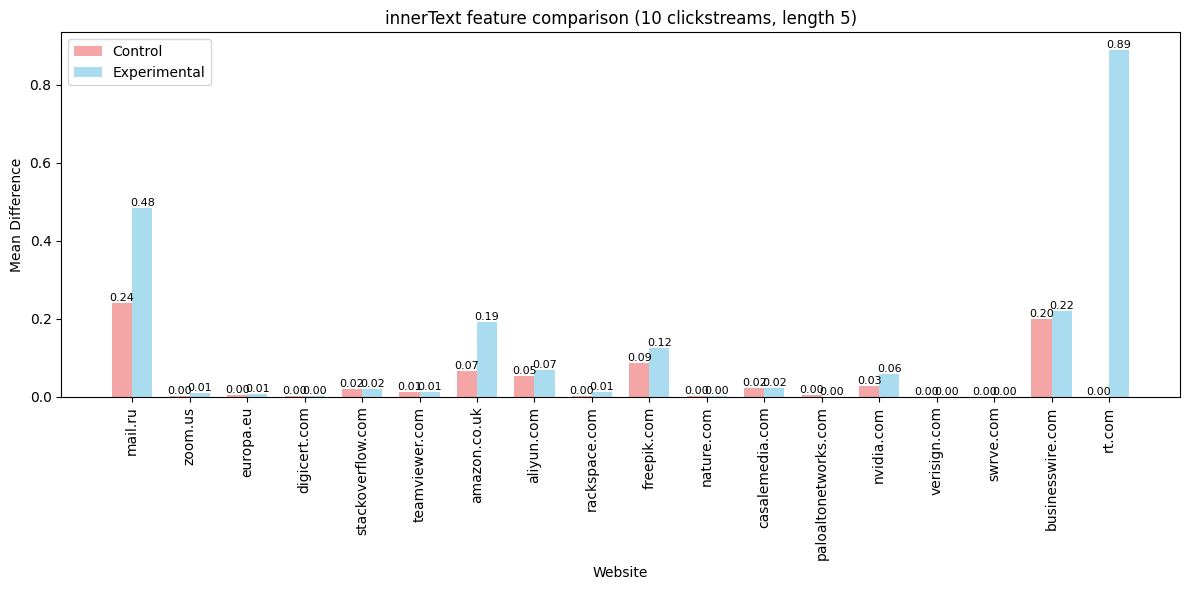

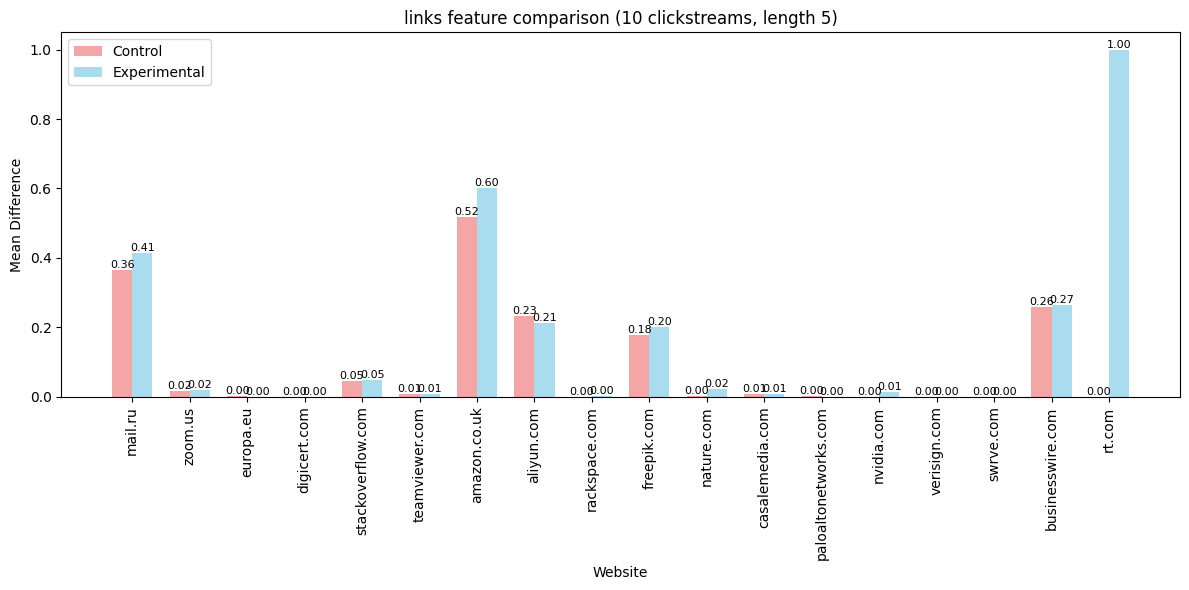

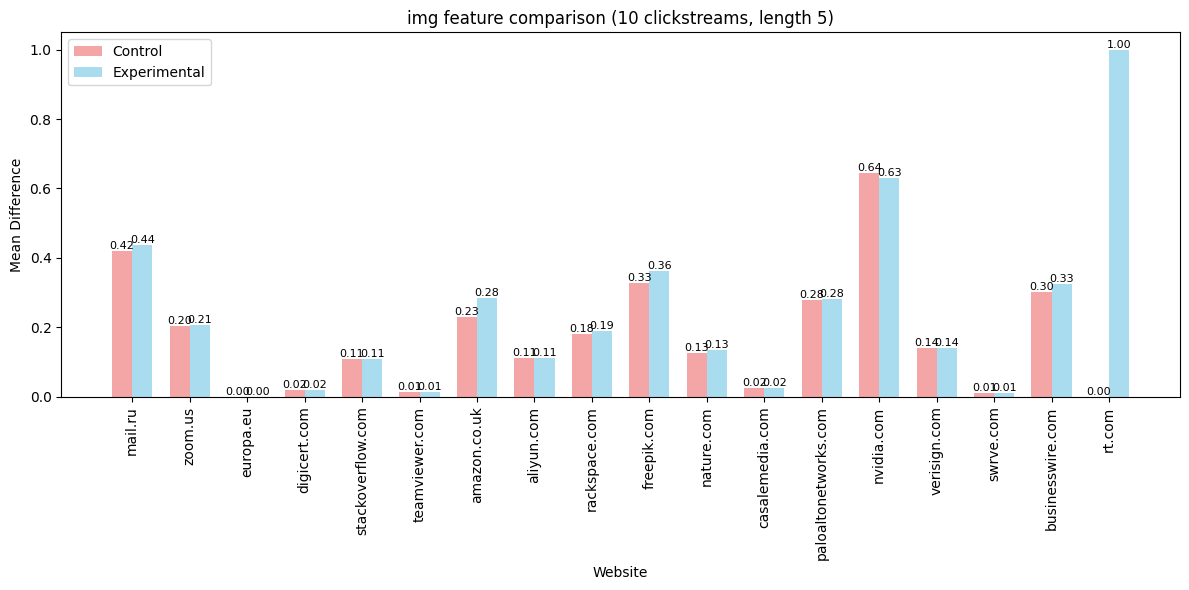

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(df: pd.DataFrame, title: str):
    # Set the x-axis labels to be the websites
    websites = df["control"]["website"]
    x = np.arange(len(websites))  # Use numpy.arange for better control

    # Set the data for the second CSV (remove-third-party)
    mean_diff_control = df["control"]["mean diff"]
    stdev_control = df["control"]["stdev"]

    # Set the data for the first CSV (remove-all)
    mean_diff_experimental = df["experimental"]["mean diff"]
    stdev_experimental = df["experimental"]["stdev"]

    # Create the figure and axes for the plot
    _, ax = plt.subplots(figsize=(12, 6))

    # Define a color for the bars and error bars
    bar_color = "skyblue"

    # Width of the bars
    width = 0.35

    # Bars
    bars1 = ax.bar(x - width/2, mean_diff_control, width=width, label="Control", color="lightcoral", alpha=0.7)
    bars2 = ax.bar(x + width/2, mean_diff_experimental, width=width, label="Experimental", color=bar_color, alpha=0.7)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(websites, rotation=90)

    # Set labels and title
    ax.set_xlabel("Website")
    ax.set_ylabel("Mean Difference")
    ax.set_title(f"{title} feature comparison (10 clickstreams, length 5)")

    # Add a legend
    ax.legend()

    # Customize the error bars to match the bar color and add horizontal lines
    # error_kw = {'capsize': 5, 'ecolor': 'lightcoral', 'color': 'lightcoral'}
    # ax.bar(x - width/2, mean_diff_control, width=width, yerr=stdev_control, alpha=0, error_kw=error_kw)
    
    # error_kw = {'capsize': 5, 'ecolor': bar_color, 'color': bar_color}
    # ax.bar(x + width/2, mean_diff_experimental, width=width, yerr=stdev_experimental, alpha=0, error_kw=error_kw)

    # Add text labels for the values at the top of each bar
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.annotate(f"{height1:.2f}", (bar1.get_x() + bar1.get_width() / 2, height1),
                    ha="center", va="bottom", fontsize=8)
        ax.annotate(f"{height2:.2f}", (bar2.get_x() + bar2.get_width() / 2, height2),
                    ha="center", va="bottom", fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()

for feature in results:
    plot_comparison(results[feature], feature)

In [122]:
#
# NOTE: The compare_clickstream algorithm is not correct! We take an average of averages, which is not correct.
#

# Two comparison algorithm
# control = compare_clickstreams("baseline", "control", "control")
# experimental = compare_clickstreams("baseline", "experimental", "remove_cookies")
# merged_df = control.merge(experimental, on=["website"])

# Chunk comparison algorithm
# control_comparison = compare_with_control()

In [123]:
# control_comparison.to_csv(f'analysis/{CRAWL_NAME}.csv', index=False)